In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller

In [2]:
mandi_data = pd.read_csv('Seasonality_Type_Detected_Data.csv')

In [3]:
temp_df= mandi_data.groupby(['APMC','commodity','Seasonality_Type']).size().reset_index().rename(columns={0:'Frequency'})
temp_df.head()

,APMC,commodity,Seasonality_Type,Frequency
0,Aamgaon,paddy-unhusked,Additive,27
1,Akhadabalapur,soybean,Additive,27
2,Akluj,bitter gourd,Additive,27
3,Akluj,brinjal,Multiplicative,26
4,Akluj,cabbage,Additive,27


# We wish to design a funcction that uses the Seasonal_decompose method to remove the seasonal component of the data
-  for each unique set of APMC/Mandi's and Commodities
-  We do this for all the unique pairs and append Deseasonalized prices to the output dataset

In [4]:
def Deseasonalize_Modal_Price(dframe,model):
    
    df = dframe[['date','modal_price']]
    df['date'] = pd.to_datetime(df['date'])
    dframe['date'] = pd.to_datetime(dframe['date'])
    df = df.sort_values(by=['date'])
    dframe = dframe.sort_values(by=['date'])
    df = df.set_index('date')
    
    
    if model == 'Additive':
        dec = seasonal_decompose(df.values,model='additive',freq=3)
        ses = list(dec.seasonal)
        dframe.reset_index(inplace=True,drop=True)
        for i in range(len(df)):
            dframe.loc[i,'Deseasonalized_Price'] = int((dframe.loc[i,'modal_price'])-ses[i])
            
    else:
        dec = seasonal_decompose(df.values,model='multiplicative',freq=3)
        ses = list(dec.seasonal)
        dframe.reset_index(inplace=True,drop=True)
        for i in range(len(df)):
            dframe.loc[i,'Deseasonalized_Price'] = int((dframe.loc[i,'modal_price'])-ses[i])
            
    
    return dframe

In [5]:
resultant_df = pd.DataFrame()
mandi_data['Deseasonalized_Price'] = np.nan
for i,row in temp_df.iterrows():
    dframe_1 = mandi_data[(mandi_data['APMC']==row.APMC)&(mandi_data['commodity']==row.commodity)]
    output_df = Deseasonalize_Modal_Price(dframe_1,row.Seasonality_Type)
    resultant_df = pd.concat([output_df,resultant_df])

In [9]:
resultant_df.head()

,APMC,commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,Seasonality_Type,Deseasonalized_Price
0,Yeotmal,soybean,2014,September,2162,3063,3379,3225.0,2014-09-01,Yewatmal,Multiplicative,3224.0
1,Yeotmal,soybean,2014,October,10548,2906,3229,3070.0,2014-10-01,Yewatmal,Multiplicative,3068.0
2,Yeotmal,soybean,2014,November,29381,3000,3327,3162.0,2014-11-01,Yewatmal,Multiplicative,3160.0
3,Yeotmal,soybean,2014,December,18921,3014,3300,3163.0,2014-12-01,Yewatmal,Multiplicative,3162.0
4,Yeotmal,soybean,2015,January,19595,3009,3340,3176.0,2015-01-01,Yewatmal,Multiplicative,3174.0


# So, we have Deseasonalized our Modal_Price for each unique APMC,Commodity Pair, Moving on-
-  We define a test Statistic - Augmented Dickey Fuller Test, to further strenghten the confidence of our result
  -  We choose 95% confidence interval as standard for our statistic strength
  -  This test gives a quantifiable measure that defines stationarity of Time-Series data
  -  p-value if >0.05, we accept the null hypothesis and data is non-stationary, i.e Seasonal factor exists
  -  But,p-value is <0.05, we reject the null hypothesis and data is stationary, i.e Seasonal factor removed
-  We finally plot a few of the datapoints, to observe the diffrence between observed and deseasonalized values
-  Lastly, we export this dataset to complete this task and move ahead with our analysis

In [58]:
def ADF_Test_Result(df):  
    test_Statistic = adfuller(df,autolag = 't-stat')
    cvs=[]
    for cv,value in test_Statistic[4].items():
        cvs.append(cv)
    print('ADF Statistic:      %f' % (test_Statistic[0]))
    print('p-value:            %f' % (test_Statistic[1]))
    print('Critical_Value for 99% Confidence : {}' .format(test_Statistic[4][cvs[1]]))

In [59]:
# Random Data samples 
test_df = resultant_df[(resultant_df['APMC']=='Yeola')&(resultant_df['commodity']=='gram')]

In [60]:
ADF_Test_Result(test_df.iloc[:,7].values)

ADF Statistic:      2.061119
p-value:            0.998747
Critical_Value for 99% Confidence : -3.0420456927297668


In [61]:
ADF_Test_Result(test_df.iloc[:,11].values)

ADF Statistic:      0.095223
p-value:            0.965733
Critical_Value for 99% Confidence : -3.005425537190083


# Observation-
-  p value decreases , thus time-stationarity has been improved, but not completely
-  Absolute ADF test Statistic value decreases, thus surely, time-stationarity of dataset has been significantly improved

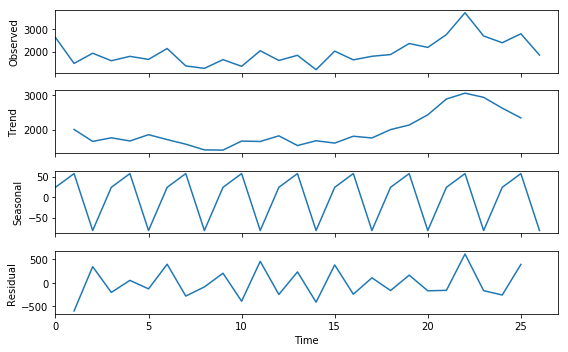

In [102]:
test_df1 = resultant_df[(resultant_df['APMC']=='Mumbai')&(resultant_df['commodity']=='small gourd')]
plot_df = test_df1[['date','modal_price']]
plot_df.set_index('date',inplace=True)
decompose = seasonal_decompose(plot_df.values,model='additive',freq=3)
decompose.plot()
plt.savefig('Seasonality1.png',dpi=200)

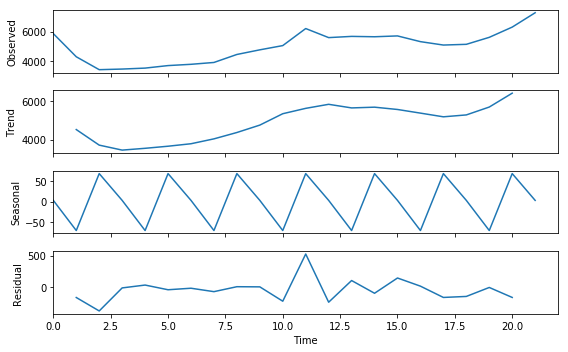

In [103]:
test_df2 = resultant_df[(resultant_df['APMC']=='Pune')&(resultant_df['commodity']=='gram')]
plot_df1 = test_df2[['date','modal_price']]
plot_df1.set_index('date',inplace=True)
decompose = seasonal_decompose(plot_df1.values,model='additive',freq=3)
decompose.plot()
plt.savefig('Seasonality12.png',dpi=200)

# Plotting Modal_Prices and Deseasonalized prices for a few pairs

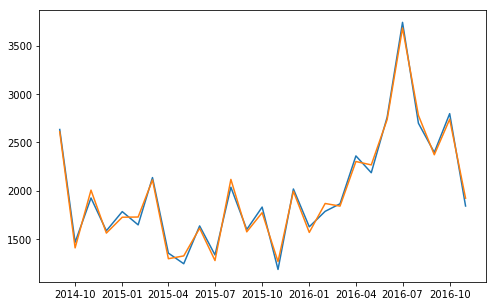

In [104]:
X = resultant_df[(resultant_df['APMC']=='Mumbai')&(resultant_df['commodity']=='small gourd')]
plt.plot(X['date'],X['modal_price'])
plt.plot(X['date'],X['Deseasonalized_Price'])
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
plt.savefig('De-Seasonality1.png',dpi=200)

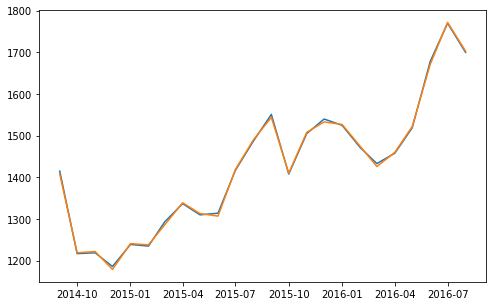

In [105]:
Y = resultant_df[(resultant_df['APMC']=='Akluj')&(resultant_df['commodity']=='maize')]
plt.plot(Y['date'],Y['modal_price'])
plt.plot(Y['date'],Y['Deseasonalized_Price'])
plt.savefig('De-Seasonality2.png',dpi=200)

# Observations - 
-  We observe high seasonality in the time-series data, evident from the Seasonal component of the decomposed data
-  We also observe removing the seasonal component smoothes the curve of prices, hence a more practical prediction can be made
-  Finally, we have a dataset, that is Deseasonalized, let's export it for price comparisons with MSP_data

In [95]:
resultant_df.to_csv("Deseasonalized_Mandi_Prices.csv",index=False)